## **importing libraries**

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import plot_model

## **Importing Dataset**

In [12]:
train_dir = '/Users/vutrang/Documents/VMD/archive/train/'
test_dir = '/Users/vutrang/Documents/VMD/archive/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       happy   sad  fear  surprise  neutral  angry  disgust
train   7215  4830  4097      3171     4965   3995      436
      happy   sad  fear  surprise  neutral  angry  disgust
test   1774  1247  1024       831     1233    958      111


## **Thống kê số lượng phần tử trong từng tập train/ test**

**Biểu diễn số lượng ảnh trong tệp train**

Text(0.5, 1.0, 'Plot of number of images in train dataset')

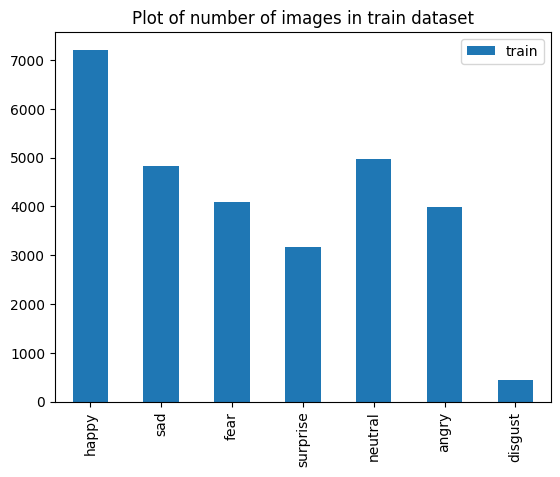

In [13]:
train_count.transpose().plot(kind="bar")
plt.title('Plot of number of images in train dataset')

**Biểu diễn số lượng ảnh trong tệp test**

Text(0.5, 1.0, 'Plot of number of images in test dataset')

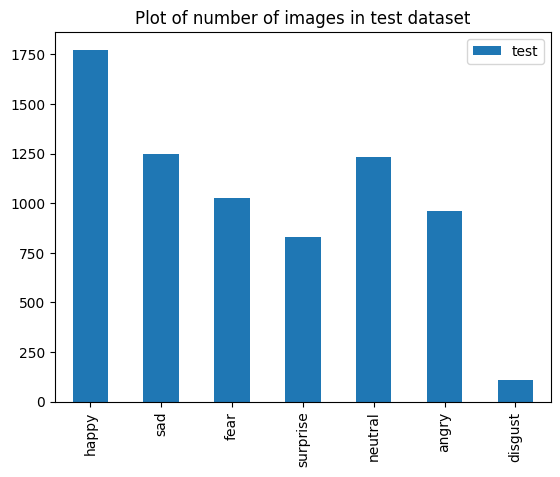

In [14]:
test_count.transpose().plot(kind="bar")
plt.title('Plot of number of images in test dataset')

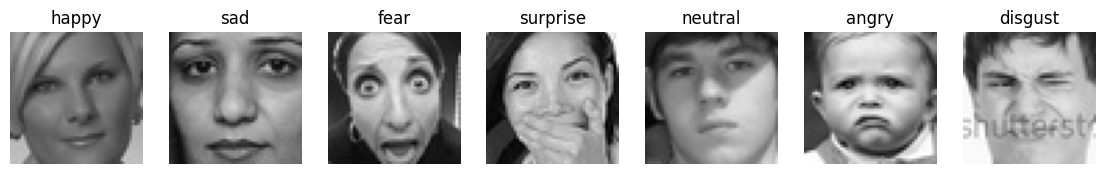

In [15]:
plt.figure(figsize=(14, 22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1, 7, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## **Tạo tập Training và Test**

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)
# rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest'
train_set = train_datagen.flow_from_directory(train_dir,
                                              batch_size=64,
                                              target_size=(48, 48),
                                              shuffle=True,
                                              color_mode="grayscale", class_mode='categorical')
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                            batch_size=64,
                                            target_size=(48, 48),
                                            shuffle=True,
                                            color_mode="grayscale", class_mode='categorical')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [17]:
train_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

##  **Xây dựng model**

In [18]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [19]:
our_model = get_model((row,col,1), classes)
our_model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-04-20 15:34:37.235386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-20 15:34:37.236072: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

## **Training Model**

In [20]:
steps_per_epoch = train_set.n // train_set.batch_size
validation_steps = test_set.n // test_set.batch_size

mod = our_model.fit(x=train_set,
                    validation_data=test_set,
                    epochs=60,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/60


2023-04-20 15:34:37.694887: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-20 15:34:38.084129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - ETA: 0s - loss: 4.2253 - accuracy: 0.2769

2023-04-20 15:35:40.506619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - 67s 147ms/step - loss: 4.2253 - accuracy: 0.2769 - val_loss: 6.0682 - val_accuracy: 0.2302
Epoch 2/60
448/448 [==============================] - 65s 145ms/step - loss: 3.4119 - accuracy: 0.3330 - val_loss: 3.0633 - val_accuracy: 0.3832
Epoch 3/60
448/448 [==============================] - 65s 144ms/step - loss: 2.8850 - accuracy: 0.3681 - val_loss: 2.5732 - val_accuracy: 0.4294
Epoch 4/60
448/448 [==============================] - 68s 152ms/step - loss: 2.4800 - accuracy: 0.3992 - val_loss: 2.1892 - val_accuracy: 0.4646
Epoch 5/60
448/448 [==============================] - 71s 159ms/step - loss: 2.1670 - accuracy: 0.4255 - val_loss: 1.9684 - val_accuracy: 0.4588
Epoch 6/60
448/448 [==============================] - 75s 168ms/step - loss: 1.9401 - accuracy: 0.4503 - val_loss: 1.7980 - val_accuracy: 0.4742
Epoch 7/60
448/448 [==============================] - 75s 168ms/step - loss: 1.7646 - accuracy: 0.4693 - val_loss: 1.6079 - val_accuracy: 0.5

In [21]:
our_model.save("model_fer2013.h5")

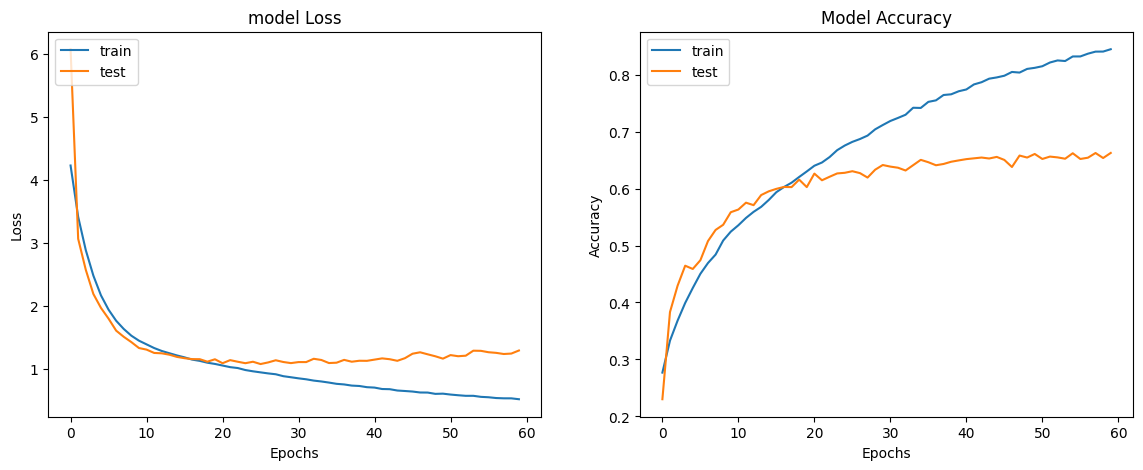

In [22]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 2)
plt.plot(mod.history['accuracy'])
plt.plot(mod.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 1)
plt.plot(mod.history['loss'])
plt.plot(mod.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Độ chính xác trên tệp Training khá cao nhưng trên tệp test lại khá thấp (xấp xỉ 66%), có thể do tập dữ liệu không cân bằng giữa các nhãn.

In [23]:
train_loss, train_accu = our_model.evaluate(train_set)
test_loss, test_accu = our_model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(
    train_accu*100, test_accu*100))

113/113 [==============================] - 5s 45ms/step - loss: 1.2945 - accuracy: 0.6624
final train accuracy = 91.42 , validation accuracy = 66.24


In [24]:
y_pred = our_model.predict(train_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v: k for k, v in class_labels.items()}

  3/449 [..............................] - ETA: 13s 

2023-04-20 16:51:31.457381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


449/449 [==============================] - 19s 42ms/step


In [25]:
cm_train = confusion_matrix(train_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_set.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 556   56  523  994  673  727  466]
 [  74    8   52  116   57   79   50]
 [ 546   48  526 1080  723  726  448]
 [ 975   95  927 1887 1196 1334  801]
 [ 699   58  615 1343  856  834  560]
 [ 663   71  637 1263  829  827  540]
 [ 448   44  428  800  574  535  342]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3995
     disgust       0.02      0.02      0.02       436
        fear       0.14      0.13      0.13      4097
       happy       0.25      0.26      0.26      7215
     neutral       0.17      0.17      0.17      4965
         sad       0.16      0.17      0.17      4830
    surprise       0.11      0.11      0.11      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



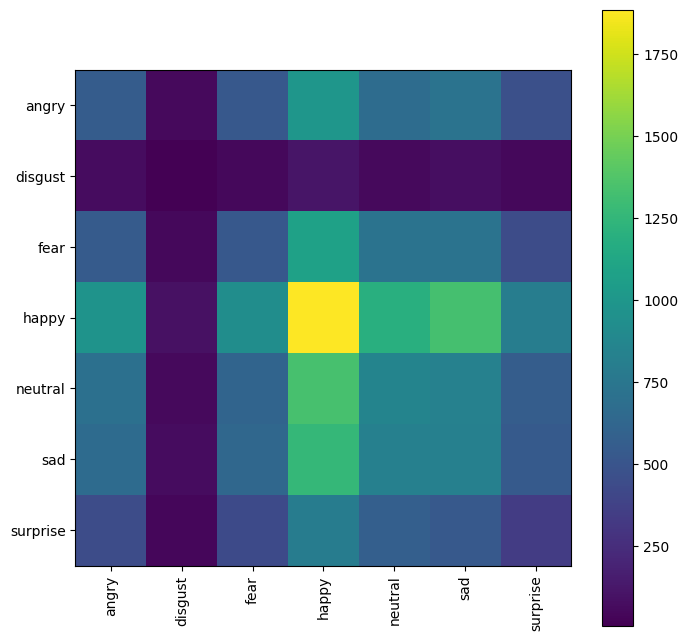

In [26]:
plt.figure(figsize=(8, 8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [27]:
y_pred = our_model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v: k for k, v in class_labels.items()}


113/113 [==============================] - 4s 39ms/step


449/449 [==============================] - 18s 40ms/step
Confusion Matrix
[[ 565   52  508 1040  699  674  457]
 [  61    2   70  100   76   89   38]
 [ 577   51  478 1080  677  758  476]
 [ 964   98  975 1899 1182 1301  796]
 [ 665   69  669 1331  828  862  541]
 [ 708   60  615 1263  854  799  531]
 [ 455   40  385  772  551  597  371]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3995
     disgust       0.01      0.00      0.00       436
        fear       0.13      0.12      0.12      4097
       happy       0.25      0.26      0.26      7215
     neutral       0.17      0.17      0.17      4965
         sad       0.16      0.17      0.16      4830
    surprise       0.12      0.12      0.12      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



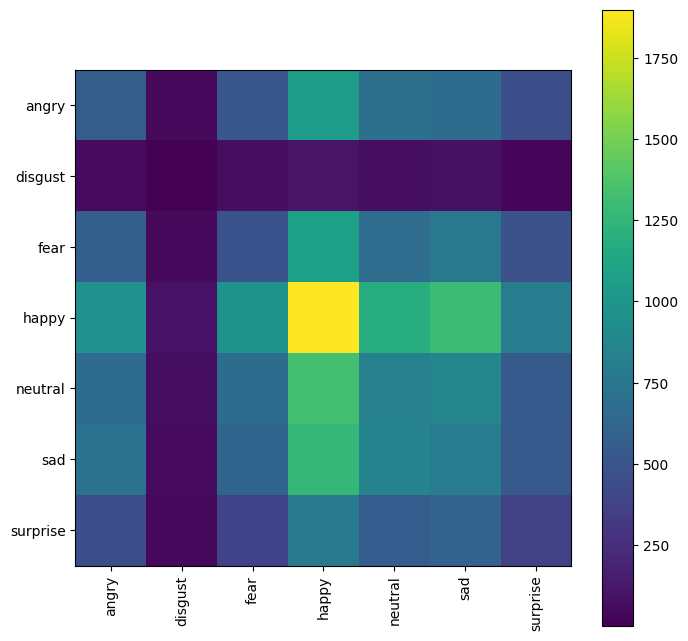

In [28]:
# ON TRAINING SET
y_pred = our_model.predict(train_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v: k for k, v in class_labels.items()}

cm_train = confusion_matrix(train_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8, 8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

113/113 [==============================] - 4s 40ms/step
Confusion Matrix
[[137   9 116 239 168 173 116]
 [ 17   1  11  29  22  15  16]
 [148   8 114 266 164 215 109]
 [256  22 184 484 317 317 194]
 [188   9 112 337 202 247 138]
 [172   8 141 327 201 246 152]
 [116   8  87 223 159 138 100]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.14      0.14       958
     disgust       0.02      0.01      0.01       111
        fear       0.15      0.11      0.13      1024
       happy       0.25      0.27      0.26      1774
     neutral       0.16      0.16      0.16      1233
         sad       0.18      0.20      0.19      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.18      0.18      0.18      7178



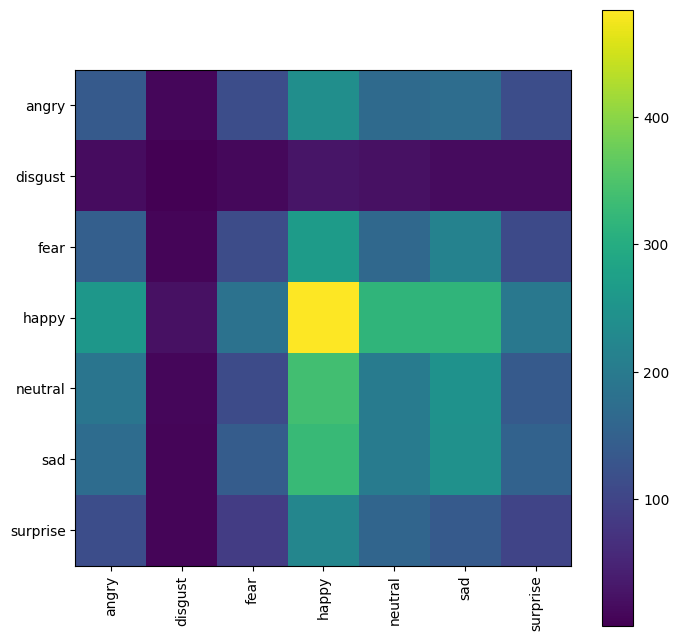

In [29]:
# ON TESTING SET
y_pred = our_model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v: k for k, v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8, 8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

## 